## Môi trường lập trình

In [ ]:
!pip install underthesea
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 35.1 MB/s eta 0:00:00


In [ ]:
## Thư viện
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
from underthesea import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from gensim.models import Word2Vec

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## Tiền xử lý dữ liệu

Tải bộ dữ liệu từ dữ liệu đã thu thập được.

In [ ]:
#https://drive.google.com/file/d/1SkqftQsfBs9rjhfuQ3MQz90_NImEdbCP/view?usp=sharing
!gdown --id 1SkqftQsfBs9rjhfuQ3MQz90_NImEdbCP

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SkqftQsfBs9rjhfuQ3MQz90_NImEdbCP
To: /content/Phản hồi và đánh giá của KH về sản phẩm gia dụng trên Tiki.csv
100% 763k/763k [00:00<00:00, 82.2MB/s]


In [ ]:
df = pd.read_csv('/content/Phản hồi và đánh giá của KH về sản phẩm gia dụng trên Tiki.csv')

### 1. Thăm dò dữ liệu

Hiển thị thông tin bộ dữ liệu.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3745 entries, 0 to 3744
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     3745 non-null   int64 
 1   comment_id     3745 non-null   int64 
 2   title          3745 non-null   object
 3   content        2844 non-null   object
 4   customer_id    3745 non-null   int64 
 5   rating         3745 non-null   int64 
 6   customer_name  3745 non-null   object
dtypes: int64(4), object(3)
memory usage: 204.9+ KB


In [ ]:
# In số giá trị duy nhất của mỗi cột
df.nunique()

Unnamed: 0       3745
comment_id       3745
title              57
content          2780
customer_id      3363
rating              5
customer_name    3253
dtype: int64

In [ ]:
# In ra số cột và dòng của bộ dữ liệu
df.shape

(3745, 7)

Loại bỏ các cột không cần thiết trong bộ dữ liệu.

In [ ]:
# Loại bỏ cột Unnamed
df = df.loc[:, df.columns != '']
# Giữ lại các cột comment_id, title, content, rating
df = pd.DataFrame(df[['comment_id', 'content',  'rating', 'title']])

df.head(5)

,comment_id,content,rating,title
0,19602047,Đẹp bóng như quản cáo .hầm canh bằng bếp từ 4l...,5,Cực kì hài lòng
1,18653687,"Đồ tốt , chính hảng , nhưng hơi mỏng , vừa tầm...",5,Cực kì hài lòng
2,10051778,Trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...,2,Không hài lòng
3,13161641,"Sản phẩm giống như hình, nắp nồi lớn nhất bị m...",5,Cực kì hài lòng
4,10690339,"giao hàng nhanh, nồi cũng tầm giá, mình chưa đ...",3,Bình thường


### 2. Làm sạch dữ liệu

#### Kiểm tra giá trị thiếu

In [ ]:
# Kiểm tra số giá trị rỗng trong mỗi cột
df.isnull().sum()

comment_id      0
content       901
rating          0
title           0
dtype: int64

In [ ]:
# Xóa các dòng chứa giá trị thiếu
# Nguyên nhân: đây là thuộc tính cần phân tích, không thể thiếu
print('Trước khi xóa dòng bị thiếu:',len(df))
df = df.dropna()
print('Sau khi xóa dòng bị thiếu:',len(df))

Trước khi xóa dòng bị thiếu: 3745
Sau khi xóa dòng bị thiếu: 2844


In [ ]:
# Kiểm tra lại số giá trị rỗng trong mỗi cột
df.isnull().sum()

comment_id    0
content       0
rating        0
title         0
dtype: int64

#### Kiểm tra giá trị nhiễu

Quan sát sơ bộ bộ dữ liệu.

In [ ]:
# In ra các giá trị trong cột rating và title
print('====================================================================================')
print(df.groupby('rating').comment_id.count().sort_values(ascending=False))
print('====================================================================================')
print(df.groupby('title').comment_id.count().sort_values(ascending=False))
print('====================================================================================')

rating
5    1888
4     365
1     293
3     185
2     113
Name: comment_id, dtype: int64
title
Cực kì hài lòng                                                                 1871
Hài lòng                                                                         354
Rất không hài lòng                                                               286
Bình thường                                                                      173
Không hài lòng                                                                   108
Bình Giữ Lạnh Tuyệt Vời                                                            1
Tạm ổn                                                                             1
Rất hài lòng                                                                       1
Rất rất thỏa mãn, recommend!                                                       1
Rất ưng ý                                                                          1
Sản phẩm bị vỡ và rỉ sét phần lưới vợt!                 

In [ ]:
# Danh sách các nhãn trong cột 'title'
title_values = ['Cực kì hài lòng', 'Hài lòng', 'Rất không hài lòng', 'Bình thường', 'Không hài lòng']
# Lọc và giữ lại những dòng có giá trị trong cột 'title' thuộc danh sách nhãn
df = df[df['title'].isin(title_values)]
# Sử dụng map để thay thế nhãn cột title bằng giá trị số
title_mapping = {'Cực kì hài lòng': 5, 'Hài lòng': 4, 'Bình thường': 3,
                 'Không hài lòng': 2, 'Rất không hài lòng': 1}
# Thực hiện numeric encoding cho bộ dữ liệu
df['title'] = df['title'].map(title_mapping)

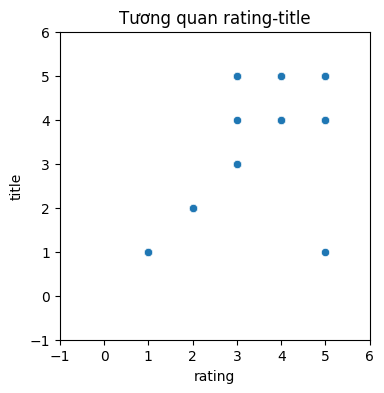

In [ ]:
# Biểu đồ phân tán
# thể hiện tương quan giữa rating và title
x_, y_ = df['rating'], df['title']

plt.figure(figsize = ([4, 4]))
plt.xlim(-1, 6) # min, max
plt.ylim(-1, 6)
plt.title('Tương quan rating-title')
plt.xlabel('rating')
plt.ylabel('title')
sns.scatterplot(x = x_, y = y_)

plt.show()

In [ ]:
# Tính độ tương đồng giữa rating và title
correlation_pearson = df['rating'].corr(df['title'])
print(f'Tương đồng Pearson: {correlation_pearson}')

Tương đồng Pearson: 0.9950122257635556


In [ ]:
# Lọc ra các dòng có rating và title khác nhau
different_rows = df.loc[df['rating'] != df['title']]

# In các dòng khác nhau
print(f"Các dòng khác nhau giữa rating và title:\n{different_rows[['comment_id', 'rating', 'title']]}")

Các dòng khác nhau giữa rating và title:
      comment_id  rating  title
154     15956961       4      5
200     13567968       3      5
467     13139221       3      4
968     15937661       5      4
1137    16833029       4      5
1366    15014777       4      5
1582    16836274       5      4
1729    12864000       3      5
1750    10167845       3      5
1854    17303087       4      5
1877    13490116       3      5
2101    16820636       5      4
2177    13177669       5      1
2658    15413125       4      5
3094    16985481       4      5
3142    14389175       3      5
3159     2224343       5      4
3284    15372447       4      5
3498    18279204       4      5


In [ ]:
# Xóa bỏ dòng có comment_id = 13177669
df = df.drop(df[df['comment_id'] == 13177669].index)

In [ ]:
# Loại bỏ cột comment_id
df = df.drop(columns='comment_id')

In [ ]:
print(f'Sau khi tiền xử lý dữ liệu, kích thước của bộ dữ liệu gồm: {df.shape[0]} dòng, {df.shape[1]} cột')

Sau khi tiền xử lý dữ liệu, kích thước của bộ dữ liệu gồm: 2791 dòng, 3 cột


In [ ]:
df.head()

,content,rating,title
0,Đẹp bóng như quản cáo .hầm canh bằng bếp từ 4l...,5,5
1,"Đồ tốt , chính hảng , nhưng hơi mỏng , vừa tầm...",5,5
2,Trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...,2,2
3,"Sản phẩm giống như hình, nắp nồi lớn nhất bị m...",5,5
4,"giao hàng nhanh, nồi cũng tầm giá, mình chưa đ...",3,3


In [ ]:
data = df [['title','content']]

In [ ]:
# Gán nhãn lại các bình luận theo 3 mức độ
label_dict = {
    5: 3,
    4: 2,
    3: 2,
    2: 1,
    1: 1
}

data['label'] = data['title'].map(label_dict)
data = data.drop(columns = ['title'])

In [ ]:
data.head()

,content,label
0,Đẹp bóng như quản cáo .hầm canh bằng bếp từ 4l...,3
1,"Đồ tốt , chính hảng , nhưng hơi mỏng , vừa tầm...",3
2,Trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...,1
3,"Sản phẩm giống như hình, nắp nồi lớn nhất bị m...",3
4,"giao hàng nhanh, nồi cũng tầm giá, mình chưa đ...",2


## Tiền xử lý văn bản

### Correct Teencode

In [ ]:
# correct teencode
teencode = {
    "không": ["kg", "ko", "hok", "hem",'k'],
    "người": ["ng"],
    "như thế nào": ["ntn"],
    "thế nào": ["tn"],
    "biết": ["pk"],
    "rồi": ["r"],
    "được": ["đc"],
    "mọi người": ["mn", "mng"],
    "sản phẩm": ["sp"],
    "bổ sung": ["p/s"],
    "sử dụng": ["sd"],
    "với": ["vs"],
    "thời gian": ["tg"],
    "thôi": ["thui"],
    "mình": ["m"],
    "nhân viên": ["nv"]
}

In [ ]:
def replace_teencode(text, teencode_dict):
    for standard_word, teencode_list in teencode_dict.items():
        for teencode in teencode_list:
            # Sử dụng biểu thức chính quy để tìm kiếm từ teencode và thay thế bằng từ chuẩn
            text = re.sub(rf'\b{teencode}\b', standard_word, text)
    return text

In [ ]:
data['content'] = data['content'].apply(lambda x: replace_teencode(x, teencode))

In [ ]:
print(data.iloc[14].to_string())

content    Phần hàn ở lắp bị hở, với giá này không kỳ vọn...
label                                                      2


### Punctuation Removal

In [ ]:
def removePunctuation(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")

    row = row.strip()
    return row

In [ ]:
data['content_1'] = data['content'].apply(removePunctuation)

data[['content', 'content_1']].head()

,content,content_1
0,Đẹp bóng như quản cáo .hầm canh bằng bếp từ 4l...,Đẹp bóng như quản cáo hầm canh bằng bếp từ 4l...
1,"Đồ tốt , chính hảng , nhưng hơi mỏng , vừa tầm...",Đồ tốt chính hảng nhưng hơi mỏng vừa tầm...
2,Trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...,Trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...
3,"Sản phẩm giống như hình, nắp nồi lớn nhất bị m...",Sản phẩm giống như hình nắp nồi lớn nhất bị m...
4,"giao hàng nhanh, nồi cũng tầm giá, mình chưa đ...",giao hàng nhanh nồi cũng tầm giá mình chưa đ...


### Lowering Text

In [ ]:
data['content_2'] = data['content_1'].apply(lambda x: x.lower())

data[['content_1', 'content_2']].head()

,content_1,content_2
0,Đẹp bóng như quản cáo hầm canh bằng bếp từ 4l...,đẹp bóng như quản cáo hầm canh bằng bếp từ 4l...
1,Đồ tốt chính hảng nhưng hơi mỏng vừa tầm...,đồ tốt chính hảng nhưng hơi mỏng vừa tầm...
2,Trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...,trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...
3,Sản phẩm giống như hình nắp nồi lớn nhất bị m...,sản phẩm giống như hình nắp nồi lớn nhất bị m...
4,giao hàng nhanh nồi cũng tầm giá mình chưa đ...,giao hàng nhanh nồi cũng tầm giá mình chưa đ...


In [ ]:
data['content_2'] = data['content_2'].apply(lambda x: replace_teencode(x, teencode))

### Tokienizer

In [ ]:
def tokenizer(row):
    return word_tokenize(row)

In [ ]:
data['content_3'] = data['content_2'].apply(tokenizer)

data[['content_2', 'content_3']].head()

,content_2,content_3
0,đẹp bóng như quản cáo hầm canh bằng bếp từ 4l...,"[đẹp, bóng, như, quản cáo, hầm, canh, bằng, bế..."
1,đồ tốt chính hảng nhưng hơi mỏng vừa tầm...,"[đồ, tốt, chính, hảng, nhưng, hơi, mỏng, vừa, ..."
2,trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...,"[trong, lúc, rửa, nồi, lần, đầu, để, sử dụng, ..."
3,sản phẩm giống như hình nắp nồi lớn nhất bị m...,"[sản phẩm, giống, như, hình nắp, nồi, lớn, nhấ..."
4,giao hàng nhanh nồi cũng tầm giá mình chưa đ...,"[giao, hàng, nhanh nồi, cũng, tầm, giá, mình, ..."


In [ ]:
data[['content', 'content_3']].head()

,content,content_3
0,Đẹp bóng như quản cáo .hầm canh bằng bếp từ 4l...,"[đẹp, bóng, như, quản cáo, hầm, canh, bằng, bế..."
1,"Đồ tốt , chính hảng , nhưng hơi mỏng , vừa tầm...","[đồ, tốt, chính, hảng, nhưng, hơi, mỏng, vừa, ..."
2,Trong lúc rửa nồi lần đầu để sử dụng thì bị đứ...,"[trong, lúc, rửa, nồi, lần, đầu, để, sử dụng, ..."
3,"Sản phẩm giống như hình, nắp nồi lớn nhất bị m...","[sản phẩm, giống, như, hình nắp, nồi, lớn, nhấ..."
4,"giao hàng nhanh, nồi cũng tầm giá, mình chưa đ...","[giao, hàng, nhanh nồi, cũng, tầm, giá, mình, ..."


### Embedding

In [ ]:
# Chia bộ dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(data['content_3'], data['label'], test_size=0.3, random_state=42)

In [ ]:
# Xây dựng mô hình W2V
min_count=1
window=3
size=300
alpha=1e-3
min_alpha=1e-4
negative=10
w2v_model = Word2Vec(min_count=min_count, window=window, vector_size=size, alpha=alpha, min_alpha=min_alpha, negative=negative, sg=1)

In [ ]:
# Truyền đầu vào là X_train để sử dụng mô hình cho tập train
word_sent_train = [sent for sent in X_train]
w2v_model.build_vocab(word_sent_train)
w2v_model.train(word_sent_train, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1, compute_loss=True)

(4353770, 5387800)

In [ ]:
# Truyền đầu vào là X_test để sử dụng mô hình cho tập test
word_sent_test = [sent for sent in X_test]

w2v_model.build_vocab(word_sent_test, update=True)  # Sử dụng update=True để không làm mất đi từ vựng đã học từ tập huấn luyện
w2v_model.train(word_sent_test, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1, compute_loss=True)

(1781809, 2206500)

In [ ]:
# Chuyển đổi văn bản sang véc tơ
def text_to_vector(text, model):
  vecs = [model.wv[word] for word in text if word in model.wv]
  if vecs:
    return np.mean(vecs, axis=0)
  else:
    return np.zeros(model.vector_size)

## Xây dựng mô hình

### Gradient Boosting (ML model)

In [ ]:
# Tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100)

# Chuyển đổi dữ liệu train và test thành vector
X_train_vec = np.array([text_to_vector(sent, w2v_model) for sent in word_sent_train])
X_test_vec = np.array([text_to_vector(sent, w2v_model) for sent in word_sent_test])

# Huấn luyện mô hình
gb_model.fit(X_train_vec, y_train)

# Dự đoán kết quả
y_pred = gb_model.predict(X_test_vec)

# In báo cáo phân loại
print(classification_report(y_test, y_pred))

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)

print("Độ chính xác của mô hình Gradient Boosting: ", accuracy)

              precision    recall  f1-score   support

           1       0.55      0.49      0.52       125
           2       0.37      0.19      0.25       150
           3       0.78      0.90      0.84       563

    accuracy                           0.71       838
   macro avg       0.57      0.53      0.54       838
weighted avg       0.67      0.71      0.68       838

Độ chính xác của mô hình Gradient Boosting:  0.7124105011933174


<Figure size 1000x600 with 0 Axes>

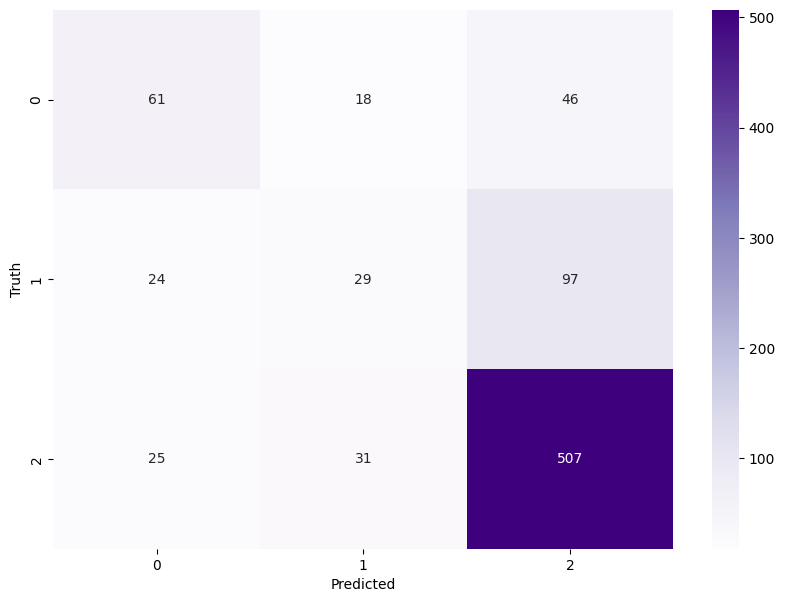

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
# Vẽ ma trận nhầm lẫn với màu sắc heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Logistic Regression (Maxent model)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Tạo mô hình Logistic Regression
lr_model = LogisticRegression()

# Huấn luyện mô hình
lr_model.fit(X_train_vec, y_train)

# Dự đoán kết quả
y_pred = lr_model.predict(X_test_vec)

# In báo cáo phân loại
print(classification_report(y_test, y_pred))

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)

print("Độ chính xác của mô hình Logistic Regression: ", accuracy)


              precision    recall  f1-score   support

           1       0.51      0.28      0.36       125
           2       0.50      0.06      0.11       150
           3       0.71      0.95      0.82       563

    accuracy                           0.69       838
   macro avg       0.57      0.43      0.43       838
weighted avg       0.64      0.69      0.62       838

Độ chính xác của mô hình Logistic Regression:  0.6921241050119332


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 1000x600 with 0 Axes>

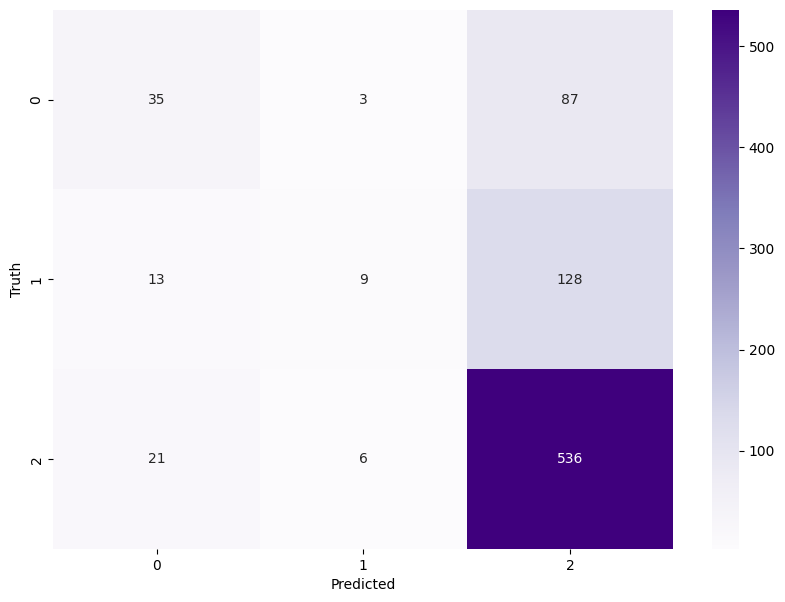

In [ ]:
plt.figure(figsize = (10,6))
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
# Vẽ ma trận nhầm lẫn với màu sắc heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### BiLSTM (DL model)

In [ ]:
# Kích thước của vector nhúng
embedding_dim = w2v_model.vector_size
# Xây dựng mô hình BiLSTM
model = Sequential()
model.add(Bidirectional(LSTM(units = 100, return_sequences=True), input_shape = (1, embedding_dim)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.2))
model.add(Dense(units = 4, activation = "softmax"))

# Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 200)            320800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 200)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 100)            100400    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 100)            60400     
 onal)                                                           
                                                        

In [ ]:
def get_vector(word_list, model):
    # Khởi tạo một vector 0
    vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
    count = 0.
    for word in word_list:
        # Thêm vector của từ vào vec
        vec += model.wv.get_vector(word).reshape((1, model.vector_size))
        count += 1.
    if count != 0:
        vec /= count
    return vec
X_train = np.concatenate([get_vector(sent, w2v_model) for sent in X_train])

In [ ]:
# Chuẩn bị dữ liệu huấn luyện
y_train = to_categorical(y_train)
X_train = X_train.reshape(-1, 1, embedding_dim)

In [ ]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
62/62 [==============================] - 19s 18ms/step - loss: 1.0305 - accuracy: 0.6595
Epoch 2/100
62/62 [==============================] - 1s 18ms/step - loss: 0.8423 - accuracy: 0.6697
Epoch 3/100
62/62 [==============================] - 1s 18ms/step - loss: 0.7940 - accuracy: 0.6697
Epoch 4/100
62/62 [==============================] - 1s 17ms/step - loss: 0.7828 - accuracy: 0.6703
Epoch 5/100
62/62 [==============================] - 1s 18ms/step - loss: 0.7627 - accuracy: 0.6743
Epoch 6/100
62/62 [==============================] - 1s 17ms/step - loss: 0.7667 - accuracy: 0.6810
Epoch 7/100
62/62 [==============================] - 1s 18ms/step - loss: 0.7487 - accuracy: 0.6851
Epoch 8/100
62/62 [==============================] - 2s 31ms/step - loss: 0.7384 - accuracy: 0.6861
Epoch 9/100
62/62 [==============================] - 2s 32ms/step - loss: 0.7344 - accuracy: 0.6897
Epoch 10/100
62/62 [==============================] - 1s 21ms/step - loss: 0.7636 - accuracy: 0.669

In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in X_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Tính toán báo cáo phân loại
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Tính toán độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

27/27 [==============================] - 4s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           1       0.57      0.33      0.42       125
           2       0.42      0.07      0.11       150
           3       0.73      0.96      0.83       563

    accuracy                           0.71       838
   macro avg       0.57      0.45      0.45       838
weighted avg       0.65      0.71      0.64       838

Accuracy: 0.7076372315035799


<Figure size 1000x600 with 0 Axes>

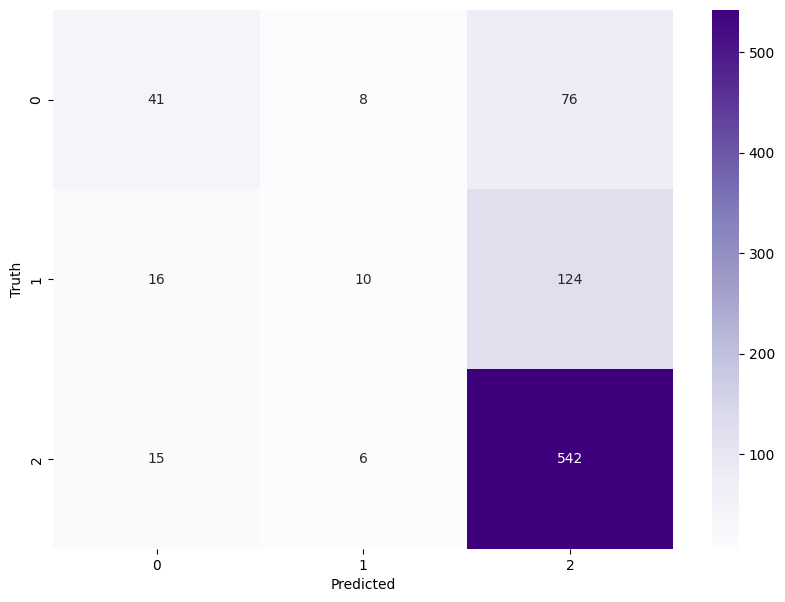

In [ ]:
plt.figure(figsize = (10,6))
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
# Vẽ ma trận nhầm lẫn với màu sắc heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## TEST: Phân lớp mức độ hài lòng dựa trên bình luận

In [52]:
while True:
  x = input("Nhập vào bình luận: ")
  x = replace_teencode(x, teencode)
  x = removePunctuation(x)
  x = x.lower()
  x = tokenizer(x)
  x = text_to_vector(x, w2v_model)
  x = x.reshape(1, -1)
  predicted_label = gb_model.predict(x)
  if predicted_label == 1:
    print("Mức độ hài lòng: Không hài lòng")
  elif predicted_label == 2:
    print("Mức độ hài lòng: Bình thường")
  else:
    print("Mức độ hài lòng: Hài lòng")
  if(input("Bạn có muốn tiếp tục (Y/N): ").upper() == "N"):
    break

Nhập vào bình luận: Đồ tốt , chính hảng , nhưng hơi mỏng , vừa tầm giá tiền cho gia đình bình dân . Đáng mua
Mức độ hài lòng: Hài lòng
Bạn có muốn tiếp tục (Y/N): Y
Nhập vào bình luận: sản phẩm chất lượng QUÁ TỆ . Chỉ mới mua về thử đun nước sôi bằng bếp điện từ thôi mà đáy nồi đã bong tróc ra như thế này , ảnh hưởng tới sức khỏe người tiêu dùng . Yêu cầu sunhouse thu hồi sản phẩm và xử lý
Mức độ hài lòng: Không hài lòng
Bạn có muốn tiếp tục (Y/N): N
